In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt

import helper
import text_embeddings
import performance
import models
import predict

# 1. Load data

In [2]:
x, y = helper.load_data()

# 2. Split data into train/test

In [3]:
x_train, x_test, y_train, y_test = helper.split_data(x, y)

In [4]:
len(x_train) 

116322

In [5]:
len(x_test)

57294

# 3. Text embedding

In [6]:
x_train_features, x_test_features, vectorizer = text_embeddings.encode_tdfif(x_train, x_test, 'text')

# 4. Grid Search using 

-  https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier
-  https://scikit-learn.org/stable/modules/kernel_approximation.html  

In [7]:
final_x_train = x_train_features['text']['data']
final_y_train = y_train

final_x_test = x_test_features['text']['data']
final_y_test = y_test

In [8]:
%%time

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint


alpha_range = [ 0.0001,0.001,0.01,0.1,1,2,3,4,5,6,7,8,9,10,50,100]
bayes = models.multinomialNB()
params = {'alpha' : alpha_range}
search = GridSearchCV(bayes,
                      params,
                      cv=5,
                      scoring="roc_auc",
                     return_train_score=True)


search.fit(final_x_train, final_y_train)
results = pd.DataFrame.from_dict(search.cv_results_)
results = results.sort_values(['param_alpha'])
results['mean_train_score-mean_test_score'] = results['mean_train_score'] - results['mean_test_score']
results[['param_alpha','mean_train_score','mean_test_score', 'mean_train_score-mean_test_score']]

CPU times: user 5.65 s, sys: 645 ms, total: 6.3 s
Wall time: 6.42 s


,param_alpha,mean_train_score,mean_test_score,mean_train_score-mean_test_score
0,0.0001,0.989655,0.980159,0.009495
1,0.001,0.989480,0.981325,0.008155
2,0.01,0.989092,0.982433,0.006660
3,0.1,0.988208,0.983091,0.005117
4,1,0.986199,0.982590,0.003610
5,2,0.985189,0.982018,0.003172
6,3,0.984483,0.981559,0.002925
7,4,0.983927,0.981181,0.002746
8,5,0.983462,0.980852,0.002610
9,6,0.983063,0.980562,0.002501


In [ ]:
# Train
plt.plot(results['param_alpha'], results['mean_train_score'], label="Train AUC")
plt.scatter(results['param_alpha'], results['mean_train_score'], label="Train AUC points")

# Validation
plt.plot(results['param_alpha'], results['mean_test_score'], label="Validation AUC")
plt.scatter(results['param_alpha'], results['mean_test_score'], label="Validation AUC points")

plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs alpha curves")
plt.legend()
plt.show()

# 5. Prediction

In [9]:
alpha = 10
naive_bayes = MultinomialNB(alpha=alpha)
naive_bayes.fit(final_x_train, final_y_train)

final_y_train_pred = naive_bayes.predict_proba(final_x_train)
final_y_test_pred = naive_bayes.predict_proba(final_x_test)


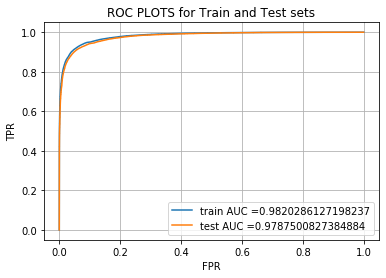

In [10]:
from sklearn.metrics import roc_curve, auc

train_fpr, train_tpr, train_thresholds = roc_curve(final_y_train, final_y_train_pred[:,1])
test_fpr, test_tpr, test_thresholds = roc_curve(final_y_test, final_y_test_pred[:,1])


plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOTS for Train and Test sets")
plt.grid()
plt.show()

# 7. Performance Measures

In [11]:
performance_measures = performance.get_performance_measures(naive_bayes, final_x_test, final_y_test)
performance_measures

{'accuracy': 0.9287883548015499,
 'f1': 0.9162630325917414,
 'confusion_matrix':              actual_0  actual_1
 predicted_0     30892      2012
 predicted_1      2068     22322,
 'roc_auc': 0.9787500827384884}

# Test

In [ ]:
predict.manual_test(naive_bayes, 
                         model_id="NB",
                         vectorizer=vectorizer)

In [29]:
test_results = predict.test_tweets_from_file(naive_bayes,
                             "bot/tweets.json",
                             model_id="NB",
                             vectorizer=vectorizer)

In [34]:
print(test_results['is_depressed(model output)'].value_counts())

0    128
1     78
Name: is_depressed(model output), dtype: int64


In [30]:
depressed_tweets = test_results[test_results['is_depressed(model output)'] == 1]

In [43]:
depressed_tweets.sort_values("model output probability (if any)", ascending=False).head(20)

,Text,is_depressed(model output),model output probability (if any)
117,I don’t know how I feel about this,1,0.986199
66,Wake up feeling like fuck my life,1,0.972719
75,You can’t even know what’s happening in that p...,1,0.955285
204,@Sassie_Lassie They should live the life they ...,1,0.933688
147,Trump has not been completely honest about any...,1,0.926096
14,Doctors don’t make you healthy. Teachers don’t...,1,0.919606
152,"My friend, it’s been a while..\nStill pains me...",1,0.908330
201,A life time ago it used to bother me what peop...,1,0.903317
62,Slowing falling down into the hole of no retur...,1,0.893720
129,Feeling Drained? Claim 5 Ways To Enjoy Better ...,1,0.889163


In [31]:
eighty = depressed_tweets[depressed_tweets['model output probability (if any)'] > 0.8]

In [32]:
eighty['Text'].values

array(['Doctors don’t make you healthy. Teachers don’t make you learn. Trainers don’t make you fit. Coaches don’t make you… https://t.co/sM4xYaYl3Y',
       'A life time ago it used to bother me what people thought about me because at the time I thought I could control it… https://t.co/hJQuhJE7bv',
       'Can’t wait to bawl my eyes out when shonda KILLS HIM LIKE EVERYONE ELSE',
       'We need stop becoming part of the problem and trying to control things and bexome part of the solution to make life… https://t.co/A4lRK5nHIy',
       'You are the reason of my life 😁💚\n#MarkTuan_OuttaMyHead \n#MarkTuan1stChineseSingle\n#MarkTuan \n#GOT7 \n@GOT7Official',
       'What is life 😪',
       'You can’t even know what’s happening in that part of my life. Never!',
       'Slowing falling down into the hole of no return my life is probably at n all time low I feel sad but no tears I wan… https://t.co/ptsm7mv8rd',
       '@Sassie_Lassie They should live the life they want to live and everyone els

# Future Work
- Explore string kernel https://github.com/timshenkao/StringKernelSVM
- word2vec using SVM (https://shop.tarjomeplus.com/UploadFileEn/TPLUS_EN_3959.pdf)
- https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/